<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Valid_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !gdown https://drive.google.com/uc?id=1p1qz1lDDwqrW-lTa11liOBMuWwIT8IP4

Downloading...
From: https://drive.google.com/uc?id=1p1qz1lDDwqrW-lTa11liOBMuWwIT8IP4
To: /content/mulitmodal_img_enc_txt.zip
100% 4.00G/4.00G [00:41<00:00, 97.2MB/s]


In [3]:
# !gdown https://drive.google.com/uc?id=1xsQZnZfm6TmzN2jMnbzC7EwjGvMTayt9

Downloading...
From: https://drive.google.com/uc?id=1xsQZnZfm6TmzN2jMnbzC7EwjGvMTayt9
To: /content/fused+joint_model.pth
100% 171M/171M [00:03<00:00, 44.9MB/s]


In [ ]:
# !unzip /content/mulitmodal_img_enc_txt.zip

In [5]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report, roc_auc_score

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Loading Validation Dataset and Preprocessing

In [ ]:
save_dir = '/content/'
load_path = os.path.join(save_dir, 'fused+joint_model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 52) # Choose the number of output classses as per your model

# Load the saved model parameters
resnet.load_state_dict(torch.load(load_path))
# resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

In [8]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, val_transform):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir)
        self.classes = self.dataset.classes
        self.val_transform = val_transform

        self.selected_indices = []
        for class_idx in range(len(self.classes)):
            indices = [idx for idx, (_, label) in enumerate(self.dataset.samples) if label == class_idx]
            indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
            indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

            self.selected_indices.extend(indices_4)
            # self.selected_indices.extend(indices_3)
        print("Selected Indices:", len(self.selected_indices))
        # for idx in self.selected_indices:
          # print(self.dataset.samples[idx][0])

    def __getitem__(self, index):
        # print("Entered get_item")
        img, label = self.dataset[self.selected_indices[index]]
        filename = self.dataset.samples[self.selected_indices[index]][0]
        image_3 = None
        image_4 = None
        if filename.endswith("_4.png"):
                image_4 = img
                image_4_path = filename
                # print("image_4_path: ", str(filename))
                image_3_path = filename.replace('_4.png', '_3.png')
                # print("image_3_path: ", str(image_3_path))
                image_3 = self._load_image(image_3_path)
        else:
                image_3 = img
                image_3_path = filename
                # print("image_3_path: ", str(filename))
                image_4_path = filename.replace('_3.png', '_4.png')
                # print("image_4_path: ", str(image_4_path))
                image_4 = self._load_image(image_4_path)

        # print("Exit get_item")
        return image_3, image_4, label, image_3_path, image_4_path

    def _load_image(self, path):
        image = Image.open(path)
        return image

    def __len__(self):
        return len(self.selected_indices)

In [10]:
valPath = "/content/mulitmodal_img_enc_txt/images-val"
val_dataset = ValidationDataset(valPath,val_transform)

Selected Indices: 21869


In [11]:
def custom_collate(batch):
    to_tensor = transforms.ToTensor()
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    images_3 = [val_transform(item[0]) for item in batch]
    images_4 = [val_transform(item[1]) for item in batch]
    labels = [torch.tensor(item[2]) for item in batch]

    images_3 = torch.stack(images_3)
    images_4 = torch.stack(images_4)

    # Print the filenames in each list
    # print("Filenames in images_3 list:")
    # for item in batch:
    #     if item[0] is not None:
    #         print(item[3])

    # print("Filenames in images_4 list:")
    # for item in batch:
    #     if item[1] is not None:
    #         print(item[4])

    return images_3, images_4, labels

In [12]:
batch_size = 16
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

In [13]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 21869
Number of classes: 52


In [14]:
num_batches = len(validation_data_loader)
print("Number of batches:", num_batches)

Number of batches: 1367


# Validation

In [15]:
resnet.eval()

# Initialize lists to store the average probabilities and true labels
predicted_labels = []
true_labels = []

# Iterate over the dataloader in your testing loop
for images_3, images_4, labels in validation_data_loader:

    images_3 = images_3.to(device)
    images_4 = images_4.to(device)

    logits_3 = resnet(images_3)
    logits_4 = resnet(images_4)
    # logits_4 = torch.zeros_like(logits_3)

    probabilities_3 = torch.softmax(logits_3, dim=1)
    probabilities_4 = torch.softmax(logits_4, dim=1)

    avg_probabilities_batch = (probabilities_3 + probabilities_4) / 2

    predicted_labels.extend(avg_probabilities_batch.cpu().tolist())

    true_labels.extend(labels)

In [16]:
predicted_classes = torch.argmax(torch.tensor(predicted_labels), dim=1)
actual_labels = torch.tensor(true_labels)

In [17]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9574740500251497
Precision: 0.957279547945846
Recall: 0.9574740500251497
F1-score: 0.9571177695269268


In [18]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.63      0.73        59
           1       0.98      0.98      0.98      1879
           2       0.98      0.97      0.98       345
           3       0.98      1.00      0.99        48
           4       0.93      1.00      0.96       132
           5       0.92      0.93      0.92       176
           6       0.98      0.99      0.99      1069
           7       0.96      0.93      0.94       148
           8       0.97      0.99      0.98       663
           9       0.98      0.99      0.99       642
          10       0.90      0.96      0.93       136
          11       0.91      0.91      0.91        35
          12       0.89      0.95      0.92       112
          13       0.97      0.97      0.97       842
          14       0.97      0.98      0.98      1555
          15       0.81      0.81      0.81        36
          16       0.96      0.86      0.91        51
          17       0.93    

In [19]:
# predicted_classes = np.array(predicted_classes)
# actual_labels = np.array(actual_labels)
# # Calculate the AUROC score
# auroc = roc_auc_score(actual_labels, predicted_classes)
# print("AUROC:", auroc)

In [20]:
# from sklearn import metrics
# fpr, tpr, _ = metrics.roc_curve(actual_labels,  predicted_classes)
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual_labels, predicted_classes)
print(cm)

[[  37    1    0 ...    1    0    0]
 [   0 1839    0 ...    0    0    4]
 [   0    0  335 ...    0    0    0]
 ...
 [   0    0    0 ...  153    0    0]
 [   0    0    0 ...    0  105    0]
 [   0    4    0 ...    0    0 2167]]


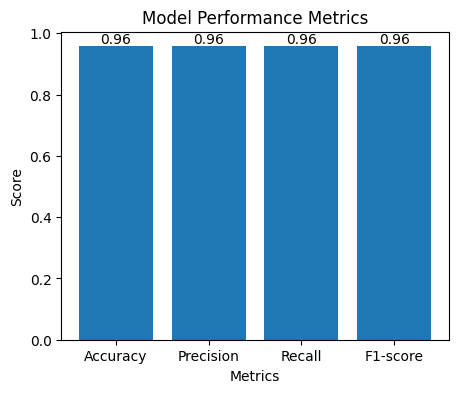

In [22]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

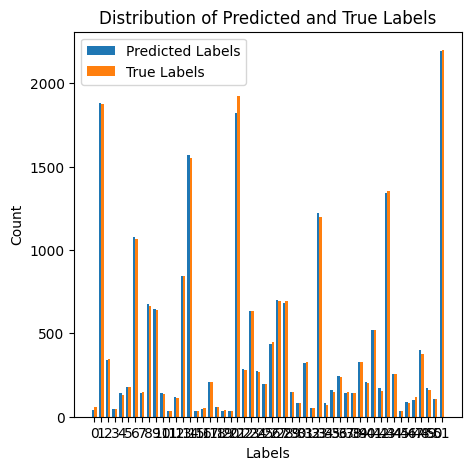

In [23]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()